In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import shears as sh
import pyreadr
from threadpoolctl import threadpool_limits

In [3]:

threadpool_limits(16)

In [4]:
# adata = sc.read_h5ad("/home/sturm/projects/2020/pircher-scrnaseq-lung/data/20_build_atlas/add_additional_datasets/03_update_annotation/artifacts/full_atlas_merged.h5ad")
# adata = adata[adata.obs["origin"] == "tumor_primary", :]
# sc.pp.subsample(adata, n_obs=20000)
# adata.write_h5ad("data/luca_20k.h5ad")

In [5]:
tcga = pyreadr.read_r(
    "/home/sturm/projects/2020/pircher-scrnaseq-lung/data/13_tcga/for_scissor/nsclc_primary_tumor.rds"
)[None]
adata_tcga = sc.AnnData(tcga.T)

/local/scratch/sturm/ipykernel_48134/1353321048.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_tcga = sc.AnnData(tcga.T)


In [6]:
tcga_meta = pd.read_csv(
    "/home/sturm/projects/2020/pircher-scrnaseq-lung/tables/tcga/clinical_data_for_scissor.tsv",
    sep="\t",
).set_index("TCGA_patient_barcode")
adata_tcga.obs = adata_tcga.obs.join(tcga_meta)

In [7]:
adata_sc = sc.read_h5ad("data/luca_20k.h5ad")

In [8]:
adata_sc_bk, adata_tcga_bk = adata_sc.copy(), adata_tcga.copy()

## Preprocessing

In this section, we are going to 
 * select the most highly variable genes
 * subset bulk and single-cell data to common genes
 * Perform quantile normalization on both single-cell and bulk data

In [9]:
# subset single-cell data to genes in bulk data. Do this *before* highly-variable gene calculation
adata_sc = adata_sc[:, adata_sc.var_names.isin(adata_tcga.var_names)]

In [10]:
sc.pp.highly_variable_genes(adata_sc, n_top_genes=2000, flavor="seurat_v3", subset=True)

/data/scratch/sturm/conda/envs/shears_dev/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [11]:
# subset bulk data to the highly variable genes
adata_tcga = adata_tcga[:, adata_sc.var_names]

In [12]:
sh.pp.quantile_norm(adata_sc)
sh.pp.quantile_norm(adata_tcga)

The same can be achieved automatically (though less flexibly) by using `func::shears.pp.recipy_shears`:

In [13]:
adata_sc, adata_tcga = sh.pp.recipe_shears(adata_sc_bk, adata_tcga_bk)

## Compute weights

This step computes a `bulk_sample` x `cell` matrix, assigning for each bulk sample a weight for each cell. 
This weight corresponds to how much this cell phenotype contributes to the bulk mixture. 

In [14]:
sh.pp.cell_weights(adata_sc, adata_tcga, n_jobs=32, alpha_callback=lambda adata: 10 * adata_sc.shape[0])

100%|██████████| 1014/1014 [00:19<00:00, 53.27it/s]


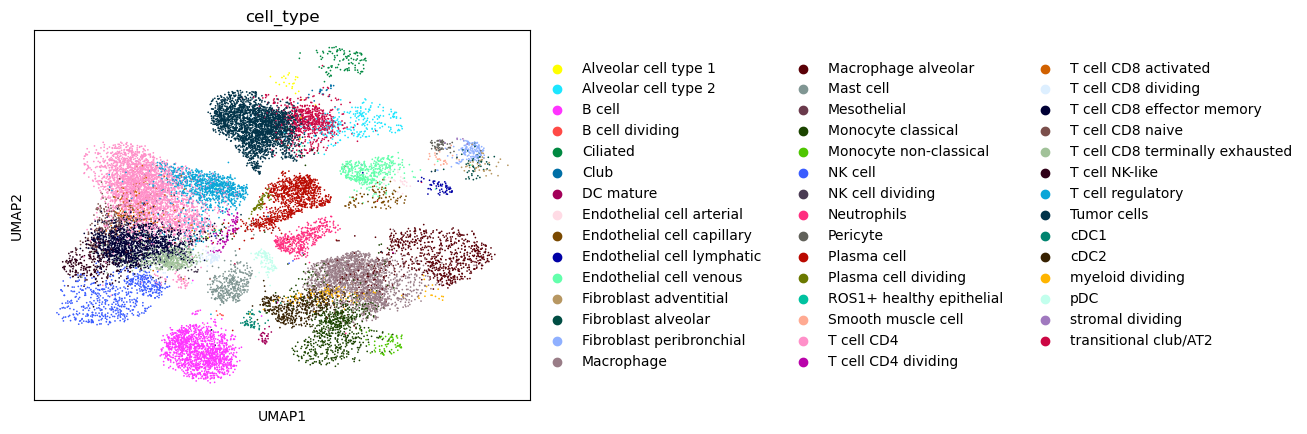

In [15]:
sc.pl.umap(adata_sc, color=["cell_type"])

In [16]:
adata_sc.obsm["cell_weights"]

TCGA-05-4244  TCGA-05-4249  TCGA-05-4250  \
GTTCGGGTCTGAGGGA-1-34-8               0.0  0.000000e+00      0.000009   
TACTTACCATGTAGTC-1_7-1                0.0  0.000000e+00      0.000000   
GTGCAGCGTAGCAAAT-1_1-1                0.0  0.000000e+00      0.000024   
CTACACCAGACACGAC-1-35-8               0.0  0.000000e+00      0.000000   
528658_17-3                           0.0  0.000000e+00      0.000000   
...                                   ...           ...           ...   
34_GGCCGCATACGC-20                    0.0  0.000000e+00      0.000017   
bcHVCV_0-21                           0.0  7.651049e-07      0.000000   
CATCAAGAGAGCTATA_LUNG_T31-5           0.0  0.000000e+00      0.000010   
19_ACCTTTGAGAAC-20                    0.0  0.000000e+00      0.000036   
GTGCTTCCAATCTACG-1-1-1                0.0  0.000000e+00      0.000000   

                             TCGA-05-4382  TCGA-05-4384  TCGA-05-4389  \
GTTCGGGTCTGAGGGA-1-34-8          0.000007           0.0  1.269149e-05   
TACTTACCATGTAGTC-1_7-1           0.000000           0.0  0.000000e+00   
GTGCAGCGTAGCAAAT-1_1-1           0.000000           0.0  1.576087e-05   
CTACACCAGACACGAC-1-35-8          0.000024           0.0  2.525744e-07   
528658_17-3                      0.000011           0.0  0.000000e+00   
...                                   ...           ...           ...   
34_GGCCGCATACGC-20               0.000000           0.0  4.543149e-06   
bcHVCV_0-21                      0.000000           0.0  0.000000e+00   
CATCAAGAGAGCTATA_LUNG_T31-5      0.000006           0.0  0.000000e+00   
19_ACCTTTGAGAAC-20               0.000000           0.0  0.000000e+00   
GTGCTTCCAATCTACG-1-1-1           0.000010           0.0  3.726500e-05   

                             TCGA-05-4390  TCGA-05-4395  TCGA-05-4396  \
GTTCGGGTCTGAGGGA-1-34-8      1.097930e-05      0.000003      0.000000   
TACTTACCATGTAGTC-1_7-1       1.408814e-07      0.000001      0.000000   
GTGCAGCGTAGCAAAT-1_1-1       1.823053e-05      0.000016      0.000000   
CTACACCAGACACGAC-1-35-8      4.376378e-05      0.000004      0.000000   
528658_17-3                  0.000000e+00      0.000000      0.000000   
...                                   ...           ...           ...   
34_GGCCGCATACGC-20           7.863694e-06      0.000026      0.000000   
bcHVCV_0-21                  4.394769e-06      0.000000      0.000005   
CATCAAGAGAGCTATA_LUNG_T31-5  6.752151e-06      0.000000      0.000000   
19_ACCTTTGAGAAC-20           5.133079e-06      0.000065      0.000000   
GTGCTTCCAATCTACG-1-1-1       5.850996e-05      0.000031      0.000000   

                             TCGA-05-4397  ...  TCGA-NK-A5CX  TCGA-NK-A5D1  \
GTTCGGGTCTGAGGGA-1-34-8          0.000003  ...      0.000000  0.000000e+00   
TACTTACCATGTAGTC-1_7-1           0.000002  ...      0.000004  2.430768e-07   
GTGCAGCGTAGCAAAT-1_1-1           0.000015  ...      0.000000  0.000000e+00   
CTACACCAGACACGAC-1-35-8          0.000000  ...      0.000018  0.000000e+00   
528658_17-3                      0.000000  ...      0.000000  0.000000e+00   
...                                   ...  ...           ...           ...   
34_GGCCGCATACGC-20               0.000000  ...      0.000001  0.000000e+00   
bcHVCV_0-21                      0.000000  ...      0.000000  5.415448e-07   
CATCAAGAGAGCTATA_LUNG_T31-5      0.000000  ...      0.000000  0.000000e+00   
19_ACCTTTGAGAAC-20               0.000018  ...      0.000060  1.930234e-05   
GTGCTTCCAATCTACG-1-1-1           0.000023  ...      0.000000  0.000000e+00   

                             TCGA-NK-A7XE  TCGA-O2-A52N  TCGA-O2-A52Q  \
GTTCGGGTCTGAGGGA-1-34-8          0.000000  0.000000e+00      0.000010   
TACTTACCATGTAGTC-1_7-1           0.000005  0.000000e+00      0.000002   
GTGCAGCGTAGCAAAT-1_1-1           0.000000  0.000000e+00      0.000045   
CTACACCAGACACGAC-1-35-8          0.000000  0.000000e+00      0.000008   
528658_17-3                      0.000000  0.000000e+00      0.000024   
...                    

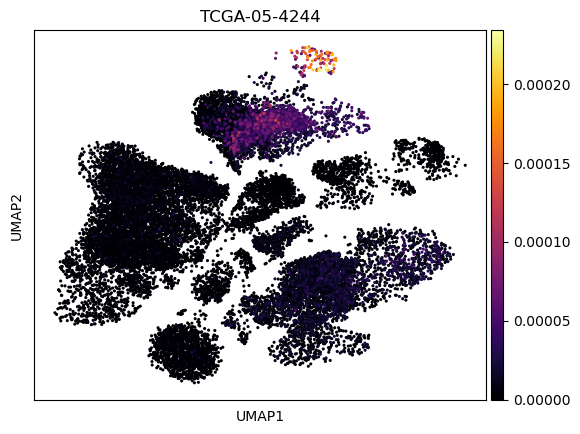

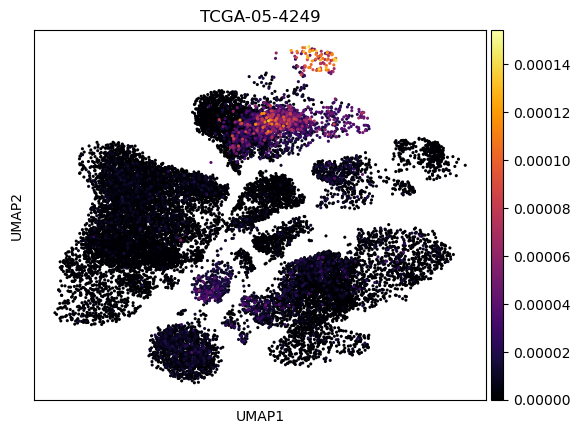

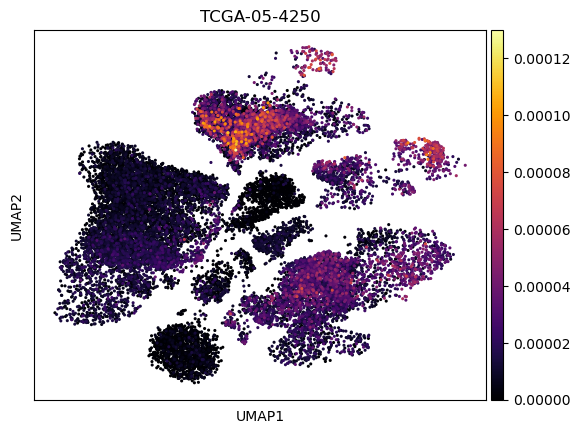

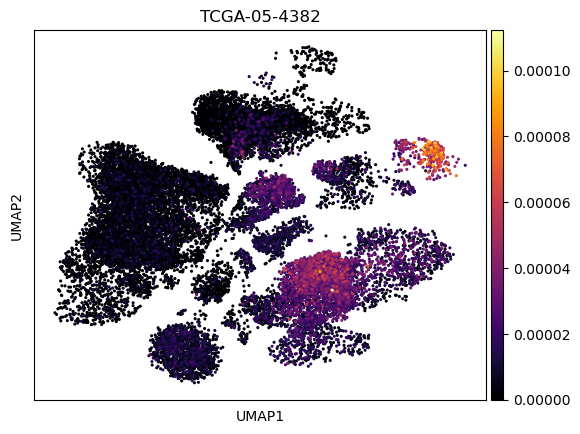

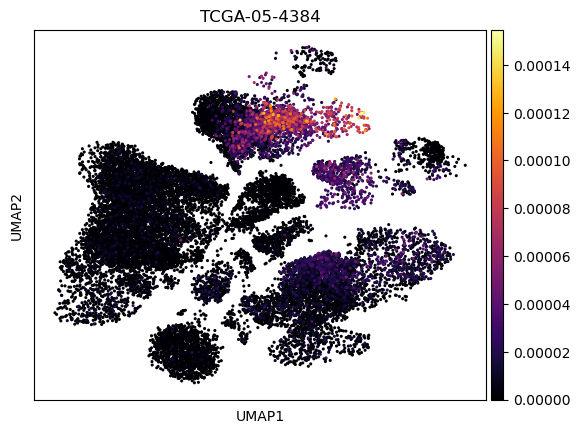

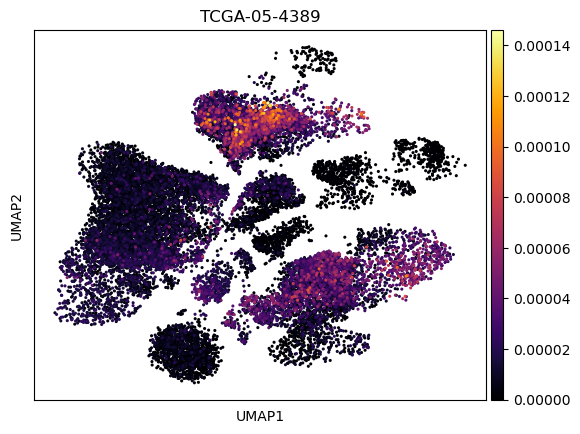

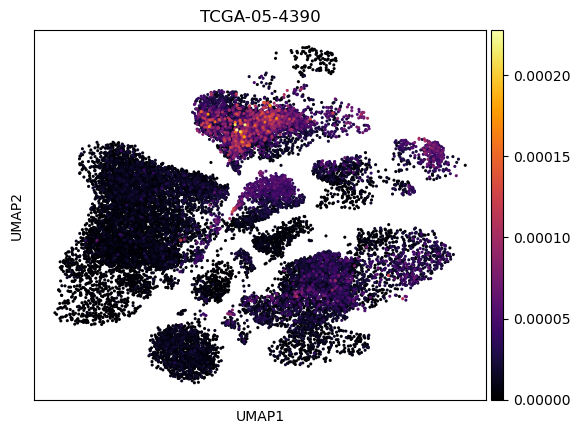

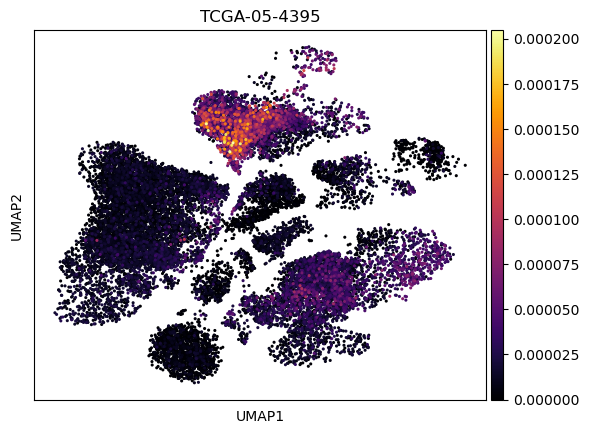

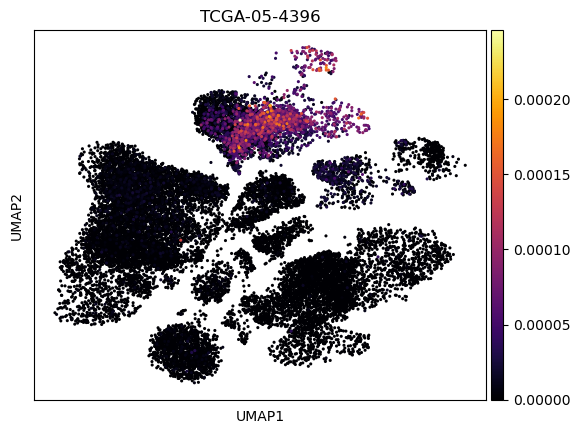

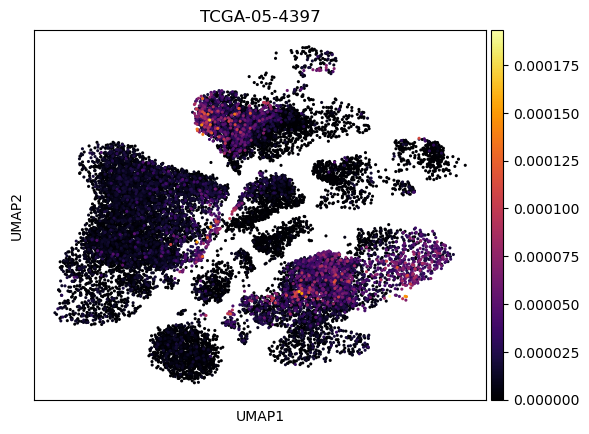

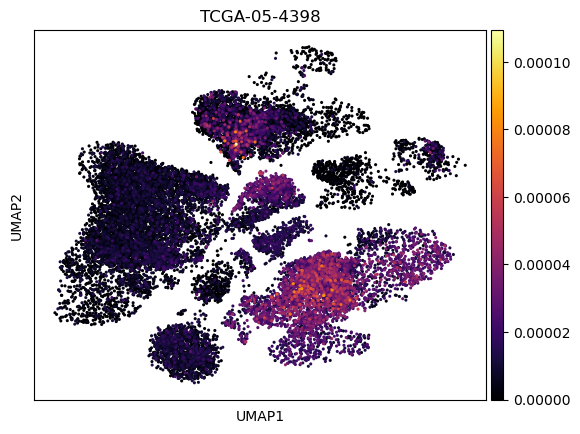

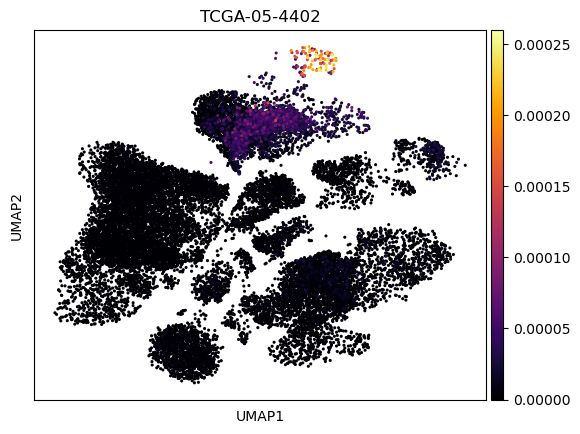

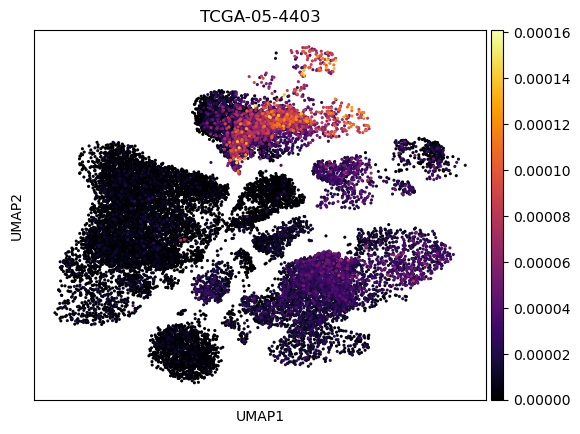

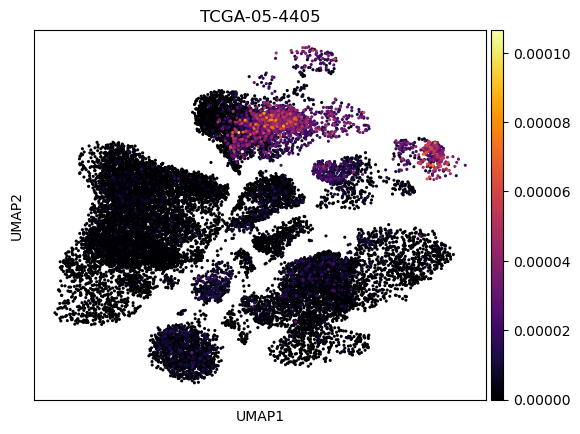

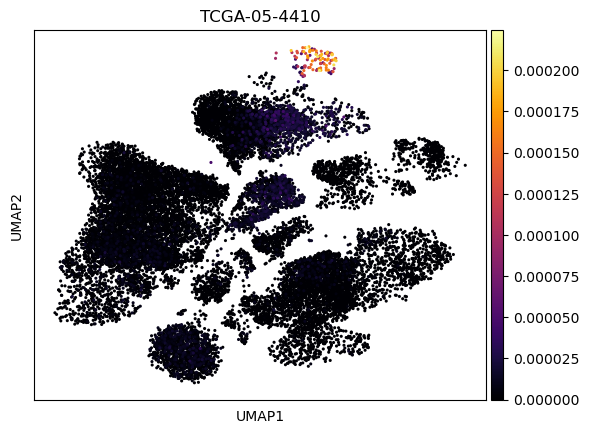

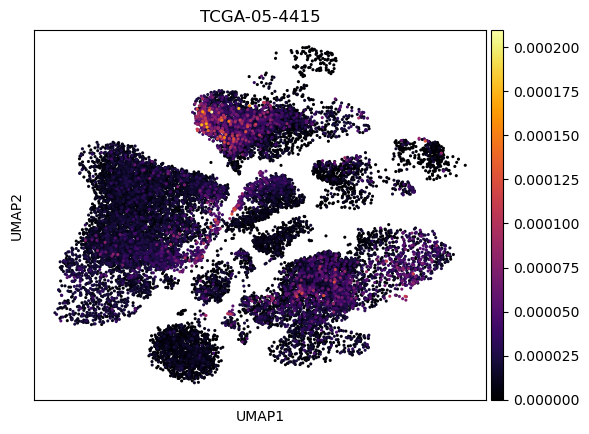

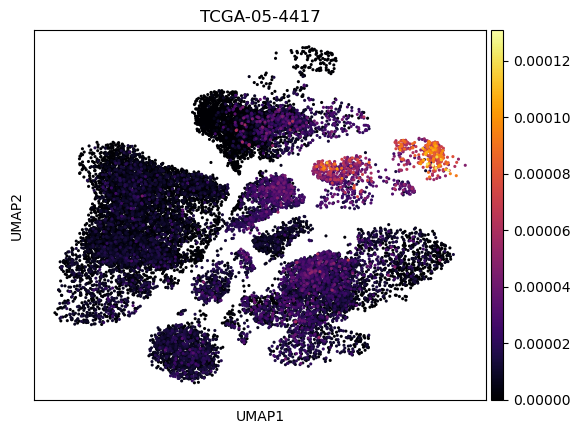

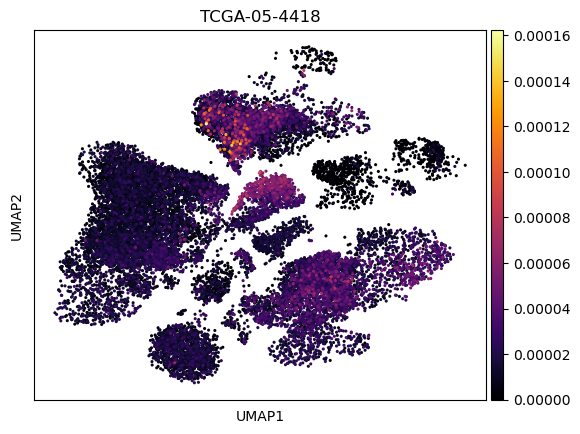

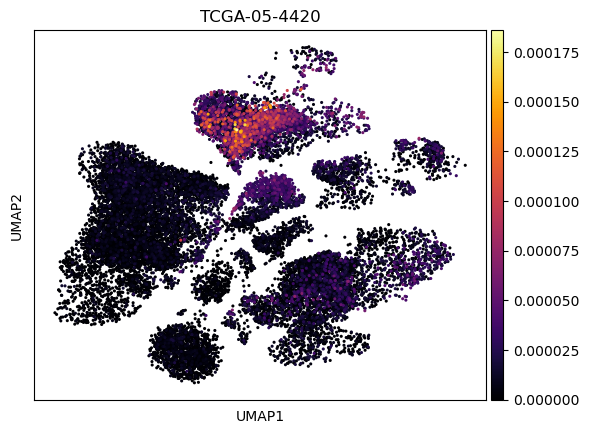

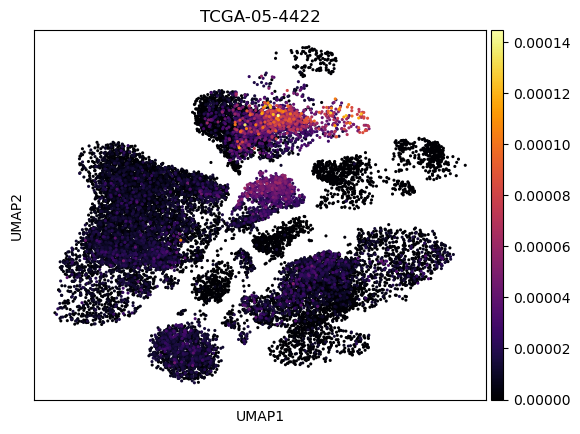

In [17]:
for p in adata_sc.obsm["cell_weights"].columns[:20].tolist():
    adata_sc.obs[p] = adata_sc.obsm["cell_weights"][p]
    sc.pl.umap(adata_sc, color=p, cmap="inferno", size=20)

## Run shears (statistical analysis)

In [18]:
adata_tcga.obs

time  status ajcc_pathologic_tumor_stage  type  \
TCGA-05-4244     0.0       0                    Stage IV  LUAD   
TCGA-05-4249  1523.0       0                    Stage IB  LUAD   
TCGA-05-4250   121.0       1                  Stage IIIA  LUAD   
TCGA-05-4382   607.0       0                    Stage IB  LUAD   
TCGA-05-4384   426.0       0                  Stage IIIA  LUAD   
...              ...     ...                         ...   ...   
TCGA-O2-A52S   387.0       1                   Stage III  LUSC   
TCGA-O2-A52V  1335.0       1                    Stage II  LUSC   
TCGA-O2-A52W   261.0       1                     Stage I  LUSC   
TCGA-O2-A5IB   340.0       1                   Stage III  LUSC   
TCGA-XC-AA0X     6.0       1                    Stage IA  LUSC   

              age_at_diagnosis  birth_days_to  gender  \
TCGA-05-4244              70.0       -25752.0    MALE   
TCGA-05-4249              67.0       -24532.0    MALE   
TCGA-05-4250              79.0       -29068.0  FEMALE   
TCGA-05-4382              68.0       -24868.0    MALE   
TCGA-05-4384              66.0       -24411.0    MALE   
...                        ...            ...     ...   
TCGA-O2-A52S              57.0       -21182.0  FEMALE   
TCGA-O2-A52V              75.0       -27449.0  FEMALE   
TCGA-O2-A52W              63.0       -23156.0    MALE   
TCGA-O2-A5IB              71.0       -26211.0  FEMALE   
TCGA-XC-AA0X              77.0       -28211.0  FEMALE   

              response_to_chemotherapy tumor_stage_ajcc   age  tumor_stage  \
TCGA-05-4244                       NaN         Stage IV  71.0          1.0   
TCGA-05-4249                       NaN          Stage I  67.0          0.0   
TCGA-05-4250                       NaN        Stage III  80.0          1.0   
TCGA-05-4382                       NaN          Stage I  68.0          0.0   
TCGA-05-4384                       0.0        Stage III  67.0          1.0   
...                                ...              ...   ...          ...   
TCGA-O2-A52S                       NaN        Stage III  58.0          1.0   
TCGA-O2-A52V                       NaN         Stage II  75.0          0.0   
TCGA-O2-A52W                       NaN          Stage I  63.0          0.0   
TCGA-O2-A5IB                       NaN        Stage III  72.0          1.0   
TCGA-XC-AA0X                       NaN          Stage I  77.0          0.0   

              kras_mutation  braf_mutation  egfr_mutation  tp53_mutation  \
TCGA-05-4244              1              0              0              0   
TCGA-05-4249              1              1              0              0   
TCGA-05-4250              1              0              0              0   
TCGA-05-4382              0              1              1              1   
TCGA-05-4384              0              0              0              0   
...                     ...            ...            ...            ...   
TCGA-O2-A52S              0              0              0              0   
TCGA-O2-A52V              0              0              0              1   
TCGA-O2-A52W              0              0              0              1   
TCGA-O2-A5IB              0              0              0              1   
TCGA-XC-AA0X              0              0              0              1   

              stk11_mutation  tumor_type  random  stk11_kras_mutation  
TCGA-05-4244               1           0       0                    1  
TCGA-05-4249               0           0       0                    0  
TCGA-05-4250               0           0       0                    0  
TCGA-05-4382               0           0       0                    0  
TCGA-05-4384               0           0       1                    0  
...                      ...         ...     ...                  ...  
TCGA-O2-A52S               0           1       1                    0  
TCGA-O2-A52V               0           1       0                    0  
TCGA-O2-A52W               0           1

In [25]:
res = sh.tl.shears(adata_sc, adata_tcga, dep_var="C(type)", covariate_str=" + C(tumor_stage_ajcc) + age_at_diagnosis", n_jobs=32)

100%|██████████| 20000/20000 [00:02<00:00, 8002.20it/s] 


In [26]:
adata_sc.obs["shears"] = res["coef"]
adata_sc.obs.loc[res["pvalue"] > 0.001, "shears"] = np.nan

In [29]:
np.sum(adata_sc.obsm["cell_weights"], axis=0)

TCGA-05-4244    0.113542
TCGA-05-4249    0.075921
TCGA-05-4250    0.243659
TCGA-05-4382    0.140274
TCGA-05-4384    0.112077
                  ...   
TCGA-O2-A52S    0.141373
TCGA-O2-A52V    0.109160
TCGA-O2-A52W    0.039900
TCGA-O2-A5IB    0.086340
TCGA-XC-AA0X    0.019266
Length: 1014, dtype: float32

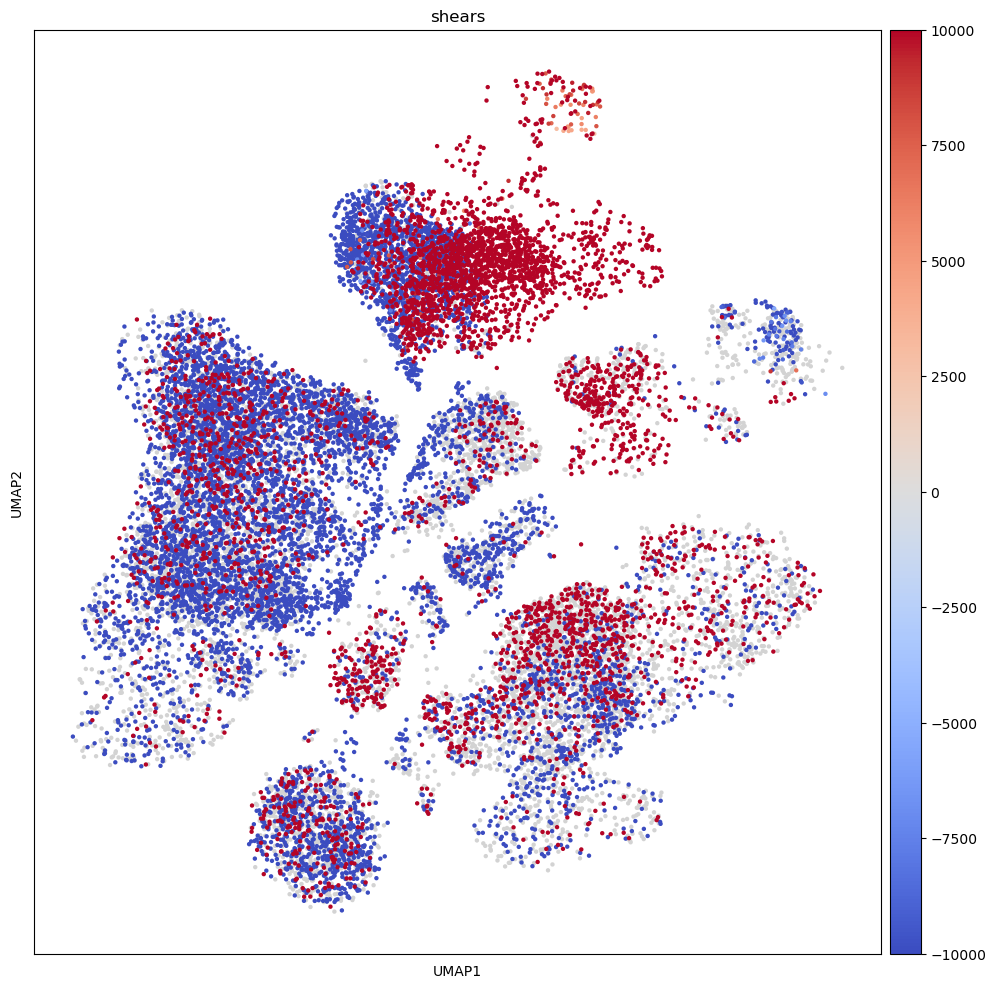

In [31]:
import matplotlib.pyplot as plt

with plt.rc_context({"figure.figsize": (12,12)}):
    sc.pl.umap(adata_sc, color="shears", cmap="coolwarm", vmin=-10000, vmax=10000, size=40)

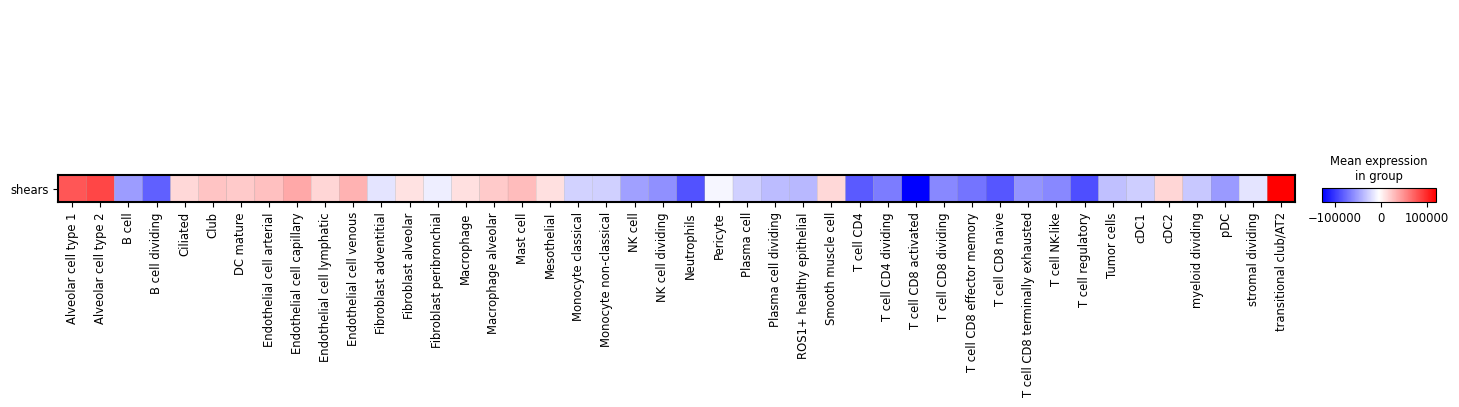

In [28]:
sc.pl.matrixplot(adata_sc, var_names="shears", groupby="cell_type", swap_axes=True, cmap="bwr")

In [34]:
res["patient"] = adata_sc.obs["patient"]
res["cell_type"] = adata_sc.obs["cell_type"]

In [37]:
score_df = res.groupby(["patient", "cell_type"]).apply(lambda df: np.mean(df["coef"] * -np.log10(df["pvalue"]))).reset_index(name="score")

In [38]:
import seaborn as sns

In [39]:
score_df

patient                   cell_type         score
0           Chen_Zhang_2020_NSCLC-1                      B cell  1.155056e+05
1           Chen_Zhang_2020_NSCLC-1  Endothelial cell capillary  3.113762e+05
2           Chen_Zhang_2020_NSCLC-1     Endothelial cell venous  6.476867e+04
3           Chen_Zhang_2020_NSCLC-1         Fibroblast alveolar  3.997117e+04
4           Chen_Zhang_2020_NSCLC-1                 Plasma cell  3.295817e+05
...                             ...                         ...           ...
2475  Zilionis_Klein_2019_patient_7  T cell CD8 effector memory  6.840595e+06
2476  Zilionis_Klein_2019_patient_7                 Tumor cells  2.116266e+06
2477  Zilionis_Klein_2019_patient_7                        cDC2  2.094715e-01
2478  Zilionis_Klein_2019_patient_7                         pDC  6.639062e+05
2479  Zilionis_Klein_2019_patient_7       transitional club/AT2  1.828865e+06

[2480 rows x 3 columns]

In [45]:
order = score_df.groupby("cell_type").agg("mean").sort_values("score").index.tolist()

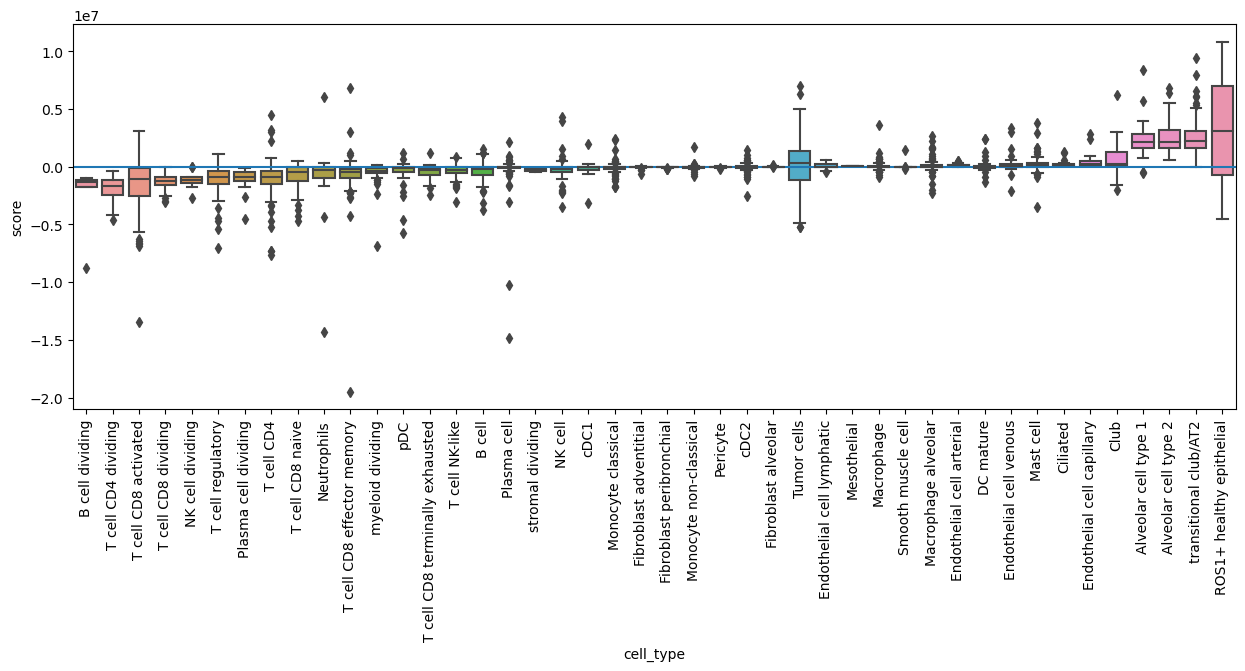

In [50]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="cell_type", y="score", data=score_df, order=order, ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(y=0)